In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot as plt
import copy
import glob
import sklearn
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
def load_dataset_group(folder_emg):
    #date_string_list = [date.strftime("%Y-%m-%d") for date in group_set]
    # load class output
    all_data = []
    # load class output
    files = glob.glob(os.path.join(folder_emg, '*.pkl'))
    files.extend(glob.glob(os.path.join(folder_emg, '*.pickle')))
     # Extract the filename from the path

    for file in files:
        filename = file.split('/')[-1]

        # Split the filename to get date and time suffix
        date_time = filename.split('.')[0]
        date, time_suffix = date_time.split('_')
        df = pd.read_pickle(file)
        df['timing'] = 0 if time_suffix=='AM' else 1
        df['date'] = date
        #all_data =pd.concat([all_data, df])
        all_data.append(df)

    return all_data


In [3]:
def get_dates(person, survey, emg_path, outcome = None):
    # get survey only for one person
    sub_survey = survey[survey['person']==person]
    # subset to days where outcome is not nan
    if outcome is not None:
        sub_survey = sub_survey[~np.isnan(sub_survey[outcome])]
    # get all available dates
    dates = sub_survey['date']
    # get all dates where we have emg data for that person
    if person == 'Johanna':
        suffix = 'JE'
    else:
        suffix = 'AB'
    files = glob.glob(os.path.join(emg_path+suffix+'/', '*.pickle'))
    dates_emg = [x.split('/')[-1].split('_')[0] for x in files]
    timing_emg = [x.split('/')[-1].split('_')[1].split('.')[0] for x in files]
    df_dates = pd.concat([pd.Series(dates_emg),pd.Series(timing_emg)],axis=1)
    df_dates['person'] = person
    return df_dates[np.isin(dates_emg,dates)].rename(columns={0:'date',1:'timing'})

In [4]:
# filter only muscle contractions and only take the 2s in the middle
def filter_muscle_contractions(df):
   start = df.loc[df['interval']=='muscle_contraction_1','START'].iloc[0]/1000 -30

   #print(start_m1)
   contraction_1 = df[(df['START']/1000 >start+31) * (df['END']/1000 <start+34)]
   contraction_2 = df[(df['START']/1000 >start+47) * (df['END']/1000 <start+50)]
   contraction_3 = df[(df['START']/1000 >start+63) * (df['END']/1000 <start+66)]

   return pd.concat([contraction_1,contraction_2,contraction_3])

# filter only tak relax and only take from 15s in until 5s before end
def filter_relax(df):
   start = df.loc[df['interval']=='muscle_contraction_1','START'].iloc[0]/1000 -30
   relax_1 = df[(df['START']/1000 >start+15) * (df['END']/1000 <start+25)]
   relax_2 = df[(df['START']/1000 >start+138) * (df['END']/1000 <start+148)]

   return pd.concat([relax_1, relax_2]).drop('interval',axis=1)

# take intermediate 10s of wallsit
def filter_wallsit(df):
   start = df.loc[df['interval']=='muscle_contraction_1','START'].iloc[0]/1000 -30
   #print(start)
   wallsit = df[(df['START']/1000 >start+93) * (df['END']/1000 <start+103)]

   return wallsit.drop('interval',axis=1)

In [5]:
def data_loader(indicators,survey,emg_path, interval =None, outcome = None):

    # dict for combining different intervals of same activity
    position_dict = {'sit_relaxed_1': 'relaxed',
    'muscle_contraction_1':'muscle_contraction',
    'muscle_contraction_2':'muscle_contraction',
    'muscle_contraction_3':'muscle_contraction',
    'wallsit':'wallsit',
    'sit_relaxed_2': 'relaxed'}

    

    data = pd.DataFrame()
    for index, row in indicators.iterrows():
        if row['person'] == 'Amanda':
            folder_indicator = 'AB'
        else:
            folder_indicator = 'JE'

        # Get a list of all files in the directory
        files = os.listdir(emg_path + folder_indicator+'/')
        # Filter the files for the specific date
        matching_files = glob.glob(os.path.join(emg_path + folder_indicator+'/', f"{row['date']}*"))
        for file in matching_files:
            df = pd.read_pickle(file)
            df['person'] = row['person']
            df['date'] = row['date']
            df['timing'] = file.split('/')[-1].split('_')[1].split('.')[0]
            df['interval_combined'] = df['interval'].map(position_dict)

            # get dummies for interval
            df = pd.concat([df, pd.get_dummies(df['interval'], dtype=int)[:-1]],axis=1)

            # get dummies for person
            # if specified filter only certain interval type
            if interval =='relax':
                df = filter_relax(df)
            if interval =='contraction':
                df = filter_muscle_contractions(df)
            if interval =='wallsit':
                df = filter_wallsit(df)
            if outcome is not None:
                y = survey[(survey['person'] ==row['person'])*(survey['date']==row['date'])][outcome]
                df[outcome] = y.iloc[0]
            data = pd.concat([data,df],axis=0)
    data = pd.concat([data, pd.get_dummies(data['person'], dtype=int).iloc[:,0]],axis=1)
    data = pd.concat([data, pd.get_dummies(data['timing'], dtype = int, ).iloc[:,0]],axis=1)

    return data

In [6]:
emg_path ='/Users/htr365/no_icloud/quantified_self_all/data/data_features/'
survey_file = '/Users/htr365/no_icloud/quantified_self_all/data/survey_data/pre_processed_survey_features.csv'
survey = pd.read_csv(survey_file)
identifiers  = pd.concat([get_dates('Amanda', survey, emg_path),get_dates('Johanna', survey, emg_path)])
# should same date but different timing not be allowed to end up in the same set?
identifiers = identifiers[['date','person']].drop_duplicates()
# train test split
indicators_train, indicators_tmp = train_test_split(identifiers, test_size=0.2, random_state=48)
indicators_val, indicators_test = train_test_split(indicators_tmp, test_size=0.5, random_state=48)

print('Train Size: ', indicators_train.shape[0])
print('Test Size: ',indicators_test.shape[0])
print('Vald Size: ', indicators_val.shape[0])

Train Size:  57
Test Size:  8
Vald Size:  7


# Classify type of activity

In [32]:
X_vars = [ 'VAR_EMG', 'RMS_EMG', 'IEMG_EMG', 'MAV_EMG', 'LOG_EMG', 'WL_EMG', 'ACC_EMG',
       'DASDV_EMG', 'WAMP_EMG', 'MYOP_EMG', 'FR_EMG', 'MNP_EMG', 'TP_EMG', 'MNF_EMG', 'MDF_EMG',  'WENT_EMG',
           'VAR_MMG', 'RMS_MMG', 'IEMG_MMG', 'MAV_MMG', 'LOG_MMG', 'WL_MMG', 'ACC_MMG',
       'DASDV_MMG', 'WAMP_MMG', 'MYOP_MMG', 'FR_MMG', 'MNP_MMG', 'TP_MMG', 'MNF_MMG', 'MDF_MMG',  'WENT_MMG','AM']
outcome = ['interval_combined']

In [33]:
identifiers  = pd.concat([get_dates('Amanda', survey, emg_path)])

In [35]:
data_train = data_loader(indicators_train,survey,emg_path)

In [40]:
data_train = data_loader(indicators_train,survey,emg_path)[X_vars+outcome].dropna()
data_val = data_loader(indicators_val,survey,emg_path)[X_vars+outcome].dropna()
data_test = data_loader(indicators_test,survey,emg_path)[X_vars+outcome].dropna()

In [8]:
#data_train = data_loader(indicators_train,survey,emg_path)[X_vars+outcome].dropna()
#data_test = data_loader(indicators_test,survey,emg_path)[X_vars+outcome].dropna()
#data_val = data_loader(indicators_val,survey,emg_path)[X_vars+outcome].dropna()

In [41]:
# get X and y for both train and test set
X_train, X_test = np.array(data_train[X_vars]), np.array(data_test[X_vars])
y_train, y_test = np.array(data_train[outcome]).flatten(), np.array(data_test[outcome]).flatten()

In [42]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

In [43]:

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6877544628875666


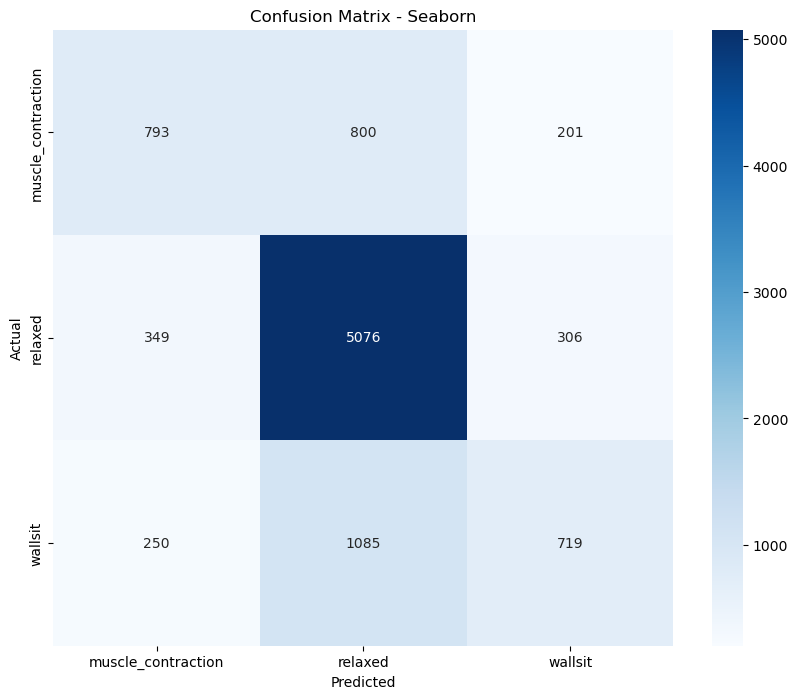

In [44]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Alternatively, plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title('Confusion Matrix - Seaborn')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Predict Person

In [14]:
#data = pd.concat([filter_muscle_contractions(data_JE),filter_muscle_contractions(data_AB)])
#data['p'] = pd.get_dummies(data['person'])['A']
#data = pd.concat([filter_relax(data_JE),filter_relax(data_AB)])
#data = pd.concat([filter_wallsit(data_JE), filter_wallsit(data_AB)])

X_vars = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV',  'WAMP', 'MYOP', "FR", "MNP", "TP",
                      "MNF", "MDF", "PKF", "WENT", 
                      #'muscle_contraction_1',
       #'muscle_contraction_2', 'muscle_contraction_3', 'prep_wallsit',
      # 'rest_1', 'rest_2', 'sit_down', 'sit_relaxed_1', 'sit_relaxed_2',
       #'wallsit'
       ]
outcome = ['person']

In [28]:
data_train = data_loader(indicators_train,survey,emg_path, interval ='relax')[X_vars+outcome].dropna()
data_test = data_loader(indicators_test,survey,emg_path, interval ='relax')[X_vars+outcome].dropna()
data_val = data_loader(indicators_val,survey,emg_path, interval ='relax')[X_vars+outcome].dropna()

In [31]:
data_test

,START,END,VAR_EMG,RMS_EMG,IEMG_EMG,MAV_EMG,LOG_EMG,WL_EMG,ACC_EMG,DASDV_EMG,...,MYOP,FR,MNP,TP,MNF,MDF,PKF,WENT,Amanda,AM
251,31375.0,31625.0,0.012126,0.168896,32.015380,0.128062,0.334282,19.182126,0.076729,0.103707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
252,31500.0,31750.0,0.013068,0.181086,35.110294,0.140441,0.351925,20.507564,0.082030,0.108314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
253,31625.0,31875.0,0.009043,0.152506,29.807105,0.119228,0.333926,18.031155,0.072125,0.092465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
254,31750.0,32000.0,0.008034,0.145250,28.574179,0.114297,0.324606,17.065490,0.068262,0.086847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
255,31875.0,32125.0,0.008123,0.138699,26.356462,0.105426,0.301379,18.104459,0.072418,0.091452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,40250.0,40500.0,0.000011,0.005920,1.220664,0.004883,0.084245,0.830647,0.003323,0.004147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
323,40375.0,40625.0,0.000011,0.005930,1.221351,0.004885,0.084510,0.857190,0.003429,0.004240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
324,40500.0,40750.0,0.000010,0.005766,1.193714,0.004775,0.083489,0.806303,0.003225,0.004078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
325,40625.0,40875.0,0.000010,0.005378,1.099841,0.004399,0.080253,0.734067,0.002936,0.003756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [29]:
data_test['person'].unique()

array(['Amanda', 'Johanna'], dtype=object)

In [25]:
data_loader(indicators_test,survey,emg_path, interval ='relax')['person'].value_counts()

person
Amanda     847
Johanna    577
Name: count, dtype: int64

In [17]:
# get X and y for both train and test set
X_train, X_test = np.array(data_train[X_vars]), np.array(data_test[X_vars])
y_train, y_test = np.array(data_train[outcome]).flatten(), np.array(data_test[outcome]).flatten()

In [18]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestClassifier(n_estimators=100, random_state=40))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

In [19]:

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


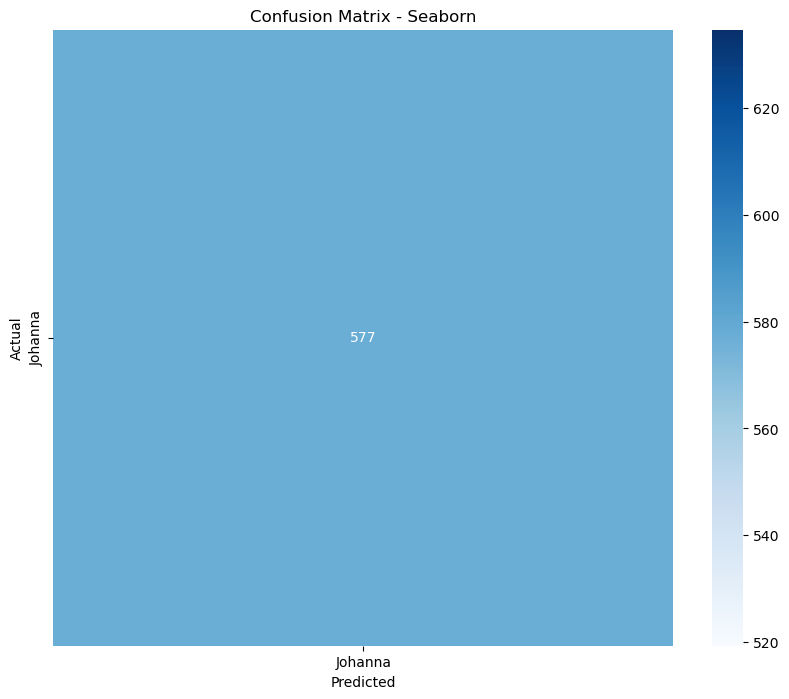

In [20]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Alternatively, plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title('Confusion Matrix - Seaborn')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Trying to classify fatigue

In [45]:
emg_path ='/Users/htr365/no_icloud/quantified_self_all/data/data_features/'
survey_file = '/Users/htr365/no_icloud/quantified_self_all/data/survey_data/pre_processed_survey_features.csv'
survey = pd.read_csv(survey_file)
identifiers  = pd.concat([get_dates('Amanda', survey, emg_path, 'hooper_muscles_sore')])

In [48]:
indicators_train, indicators_val, indicators_test = identifiers[pd.to_datetime(identifiers['date'])<pd.to_datetime('2024-08-03')],\
    identifiers[(pd.to_datetime(identifiers['date'])<pd.to_datetime('2024-08-07'))*(pd.to_datetime(identifiers['date'])>=pd.to_datetime('2024-08-03'))],\
    identifiers[pd.to_datetime(identifiers['date'])>=pd.to_datetime('2024-08-07')]

In [57]:

X_vars = [ 'VAR_EMG', 'RMS_EMG', 'IEMG_EMG', 'MAV_EMG', 'LOG_EMG', 'WL_EMG', 'ACC_EMG',
       'DASDV_EMG', 'WAMP_EMG', 'MYOP_EMG', 'FR_EMG', 'MNP_EMG', 'TP_EMG', 'MNF_EMG', 'MDF_EMG',  'WENT_EMG',
           'VAR_MMG', 'RMS_MMG', 'IEMG_MMG', 'MAV_MMG', 'LOG_MMG', 'WL_MMG', 'ACC_MMG',
       'DASDV_MMG', 'WAMP_MMG', 'MYOP_MMG', 'FR_MMG', 'MNP_MMG', 'TP_MMG', 'MNF_MMG', 'MDF_MMG',  'WENT_MMG','AM']
       
outcome = ['cis_subjective_fatigue_lead1']

In [58]:
data_train = data_loader(indicators_train,survey,emg_path, interval = 'wallsit', outcome=outcome[0])[X_vars+outcome].dropna()
data_test = data_loader(indicators_test,survey,emg_path, interval = 'wallsit', outcome=outcome[0])[X_vars+outcome].dropna()
data_val = data_loader(indicators_val,survey,emg_path,  interval = 'wallsit',outcome=outcome[0])[X_vars+outcome].dropna()

In [59]:
# get X and y for both train and test set
X_train, X_test = np.array(data_train[X_vars]), np.array(data_test[X_vars])
y_train, y_test = np.array(data_train[outcome]).flatten(), np.array(data_test[outcome]).flatten()

In [62]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

In [81]:
X_test.shape

(770, 33)

In [64]:
#accuracy = accuracy_score(y_pred,y_test)
mae= mean_absolute_error(y_pred, y_test)
print("MAE:", mae)
#print("accuracy", accuracy)

MAE: 1.0925227272727274


In [87]:
data_loader(indicators_test,survey,emg_path, interval = 'wallsit', outcome=outcome[0]).dropna(subset=X_vars+outcome)

,START,END,VAR_EMG,RMS_EMG,IEMG_EMG,MAV_EMG,LOG_EMG,WL_EMG,ACC_EMG,DASDV_EMG,...,prep_wallsit,rest_1,rest_2,sit_down,sit_relaxed_1,sit_relaxed_2,wallsit,cis_subjective_fatigue_lead1,Amanda,AM
874,109250.0,109500.0,0.000030,0.009041,1.803214,0.007213,0.101367,1.299052,0.005196,0.006964,...,0.0,0.0,0.0,0.0,0.0,NaN,1.0,5.875,1,0
875,109375.0,109625.0,0.000026,0.008381,1.666502,0.006666,0.098136,1.149370,0.004597,0.006239,...,0.0,0.0,0.0,0.0,0.0,NaN,1.0,5.875,1,0
876,109500.0,109750.0,0.000018,0.007258,1.471598,0.005886,0.093385,1.041756,0.004167,0.005697,...,0.0,0.0,0.0,0.0,0.0,NaN,1.0,5.875,1,0
877,109625.0,109875.0,0.000019,0.007169,1.428086,0.005712,0.090248,1.110532,0.004442,0.006023,...,0.0,0.0,0.0,0.0,0.0,NaN,1.0,5.875,1,0
878,109750.0,110000.0,0.000022,0.007547,1.477022,0.005908,0.091349,1.192819,0.004771,0.006522,...,0.0,0.0,0.0,0.0,0.0,NaN,1.0,5.875,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,118125.0,118375.0,0.000016,0.007157,1.482415,0.005930,0.092616,0.985332,0.003941,0.004941,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.125,1,0
946,118250.0,118500.0,0.000017,0.007361,1.522608,0.006090,0.093536,0.958906,0.003836,0.005002,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.125,1,0
947,118375.0,118625.0,0.000017,0.007230,1.485131,0.005941,0.092578,0.933316,0.003733,0.004862,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.125,1,0
948,118500.0,118750.0,0.000016,0.006612,1.322895,0.005292,0.086370,0.882741,0.003531,0.004596,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.125,1,0


In [89]:
out = pd.concat([pd.Series(y_pred).reset_index(),data_loader(indicators_test,survey,emg_path, interval = 'wallsit', outcome=outcome[0]).dropna(subset=X_vars+outcome)[['date']+outcome].reset_index()],axis=1).rename(columns={0:'pred'})
out_daily = out.groupby('date').mean('pred')

In [102]:
out_daily

,index,pred,index,cis_subjective_fatigue_lead1
date,,,,
2024-08-07,731.0,4.537662,911.0,2.125
2024-08-08,76.5,4.379391,912.5,5.875
2024-08-09,384.5,5.000633,865.0,5.375
2024-08-10,654.0,5.098766,809.0,6.500
2024-08-12,230.5,4.707427,864.0,5.750
2024-08-13,538.5,5.011916,799.5,5.250


In [100]:
np.mean(np.abs(out_daily['pred'] -np.array(out_daily[outcome]).reshape(-1)))

1.16075487012987

In [75]:
test_data_pred = pd.concat([data_loader(indicators_test,survey,emg_path, interval = 'wallsit', outcome=outcome[0])[['date']+outcome].reset_index(),pd.DataFrame(y_pred).reset_index()],axis=1)
test_data_pred

,index,date,cis_subjective_fatigue_lead1,index,0
0,875,2024-08-14,NaN,0.0,3.94375
1,876,2024-08-14,NaN,1.0,3.89875
2,877,2024-08-14,NaN,2.0,3.77750
3,878,2024-08-14,NaN,3.0,4.18500
4,879,2024-08-14,NaN,4.0,3.47750
...,...,...,...,...,...
919,945,2024-08-07,2.125,NaN,NaN
920,946,2024-08-07,2.125,NaN,NaN
921,947,2024-08-07,2.125,NaN,NaN
922,948,2024-08-07,2.125,NaN,NaN


In [1928]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(testX)

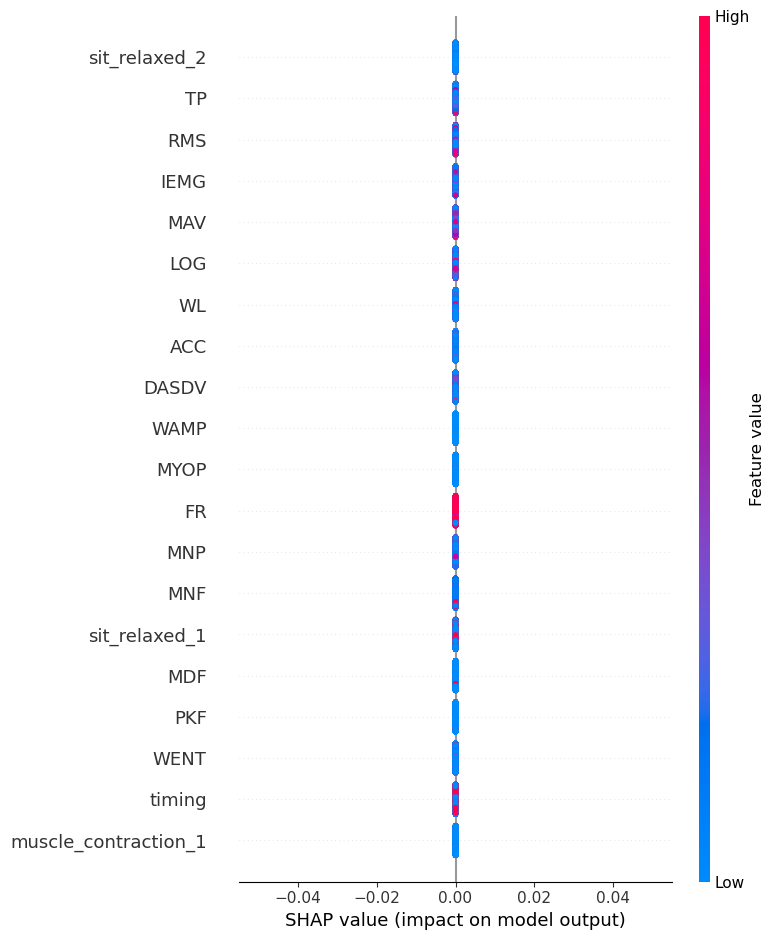

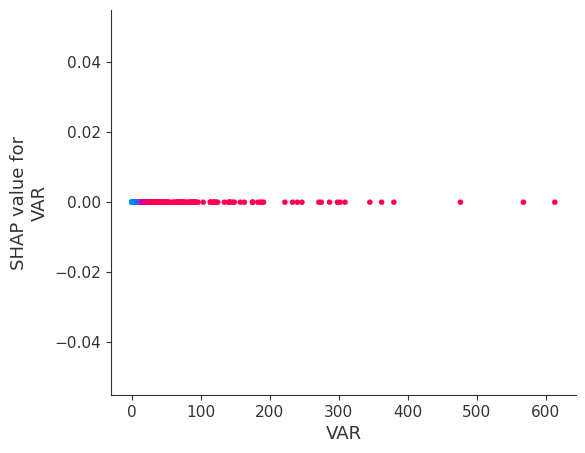

In [1929]:
# Summary plot
shap.summary_plot(shap_values, testX)

# Dependence plot for a specific feature
shap.dependence_plot(0, shap_values, testX)  # Here, 0 is the index of the feature

# CNN

In [84]:
emg_path ='/Users/htr365/no_icloud/quantified_self_all/data/data_pre_processed/'
survey_file = '/Users/htr365/no_icloud/quantified_self_all/data/survey_data/pre_processed_survey_features.csv'
survey = pd.read_csv(survey_file)
identifiers  = pd.concat([get_dates('Amanda', survey, emg_path),get_dates('Johanna', survey, emg_path)])
# should same date but different timing not be allowed to end up in the same set?
identifiers = identifiers[['date','person']].drop_duplicates()
# train test split
indicators_train, indicators_tmp = train_test_split(identifiers, test_size=0.2, random_state=48)

indicators_val, indicators_test = train_test_split(indicators_tmp, test_size=0.5, random_state=48)

print('Train Size: ', indicators_train.shape[0])
print('Test Size: ',indicators_test.shape[0])
print('Vald Size: ', indicators_val.shape[0])

Train Size:  46
Test Size:  6
Vald Size:  6


In [45]:

X_vars = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC',
       'DASDV', 'WAMP', 'MYOP', 'FR', 'MNP', 'TP', 'MNF', 'MDF', 'PKF', 'WENT', 'AM']
       
outcome = ['person']

In [7]:
data_train = data_loader(indicators_train,survey,emg_path)

In [80]:
data_test = data_loader(indicators_test,survey,emg_path,interval ='relax')
data_val = data_loader(indicators_val,survey,emg_path)[X_vars+outcome].dropna()

In [57]:
# get X and y for both train and test set
X_train, X_test = np.array(data_train[X_vars]), np.array(data_test[X_vars])
y_train, y_test = np.array(data_train[outcome]).flatten(), np.array(data_test[outcome]).flatten()

In [58]:
y_test = np.where(y_test== "Amanda", 1, 0)
y_train = np.where(y_train =='Amanda',1,0)

In [59]:
testyT = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
trainyT = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

In [82]:
np.stack([group.values[:, 1:] for name, group in data_train.groupby(['date','person'])])

ValueError: all input arrays must have the same shape

In [83]:
data_train.groupby(['date','person']).size()

date        person 
2024-06-24  Johanna    288
2024-06-25  Amanda      16
            Johanna    384
2024-06-26  Amanda       8
            Johanna    192
2024-06-27  Johanna    193
2024-06-28  Johanna    192
2024-06-29  Johanna    192
2024-06-30  Johanna    192
2024-07-03  Johanna    192
2024-07-04  Johanna    192
2024-07-06  Johanna    192
2024-07-07  Johanna    192
2024-07-08  Johanna    192
2024-07-09  Amanda       8
            Johanna    192
2024-07-10  Johanna    192
2024-07-11  Amanda      12
2024-07-12  Amanda      12
            Johanna    192
2024-07-13  Johanna    192
2024-07-14  Johanna    193
2024-07-15  Amanda      16
            Johanna    193
2024-07-16  Johanna    192
2024-07-17  Amanda      16
            Johanna    192
2024-07-18  Amanda      12
            Johanna    192
2024-07-19  Amanda      16
            Johanna    192
2024-07-20  Amanda      12
            Johanna    192
2024-07-21  Johanna    192
2024-07-22  Amanda      16
            Johanna    192
2024-07-

In [60]:

trainXT = torch.from_numpy(np.array(X_train).astype(float))
#trainXT = trainXT.transpose(2,0).transpose(2,1).float()

testXT = torch.from_numpy(X_test)
#testXT = testXT.transpose(2,0).transpose(2,1).float()
#testyT = torch.from_numpy(testy).float()
num_epochs = 300
batch_size = 5

 # [samples, time steps, features]
n_features, n_outputs = trainXT.shape[1],  trainyT.shape[0]
print(n_outputs)
#print(n_timesteps)
print(n_features)

# Train the model
total_step = n_outputs

92078


NameError: name 'n_timesteps' is not defined

In [ ]:
# define the model using pytorch
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_features, 64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(64*3,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,6),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Linear(6,1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

In [ ]:
model = ConvNet1D()

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
    #with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
       # print(i)
        model.train()
        #bar.set_description(f"Epoch {epoch}")
        #for start in bar:
        trainXT_seg = trainXT[i*batch_size:(i+1)*batch_size]
        trainyT_seg = trainyT[i*batch_size:(i+1)*batch_size]
        # Run the forward pass
        outputs = model(trainXT_seg)
        #loss = criterion(outputs, torch.max(trainyT_seg, 1)[1])
        loss = loss_fn(outputs, trainyT_seg)
        print(loss)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
        #bar.set_postfix(mse=float(loss))

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(testXT)
        mse = loss_fn(y_pred, testyT)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
     #loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        # Track the accuracy
        #total = trainyT_seg.size(0)
        #_, predicted = torch.max(outputs, 1)
        #_, actual = torch.max(trainyT_seg, 1)
       # correct = (predicted == actual).sum().item()
       # correct_sum = correct_sum + (correct/total)
       #acc_list.append(correct / total)
    #print("Epoch")
    #print(epoch)
    #print("accuracy")
    #print(correct_sum/int(np.floor(total_step/batch_size)))
    #acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))
# restore model and return best accuracy
model.load_state_dict(best_weights)
#plot the training accuracy
plt.title('Training Accuracy')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(history)
plt.show()

RuntimeError: Input type (double) and bias type (float) should be the same

# OLD STUFF

In [ ]:
def load_dataset_group(group_set,folder_emg,survey_file, person, outcomes):
    #date_string_list = [date.strftime("%Y-%m-%d") for date in group_set]
    # load class output
    survey = pd.read_csv(survey_file)
    loaded = list()
    shapes =list()
    y= list()
    intervals = list()
    for date in group_set:
        emg_am_name = date + '_AM.pickle'
        emg_pm_name = date + '_PM.pickle'

        try:
            emg_am = pd.read_pickle(folder_emg + emg_am_name)
            emg_am_interval = emg_am['interval']
            emg_am = emg_am.drop('interval',axis=1)
            print(emg_am_name)

        except:
            emg_am = np.nan
            print("Couldn't load:", emg_am_name)
        try:
            emg_pm = pd.read_pickle(folder_emg + emg_pm_name)
            emg_pm_interval = emg_pm['interval']
            print(emg_pm_interval.shape)
            emg_pm = emg_pm.drop('interval',axis=1)
            print(emg_pm_name)

        except:
            emg_pm = np.nan
            print("Couldn't load:", emg_pm_name)
        
        if not isinstance(emg_am, pd.DataFrame):
            #print(emg_pm)
            X_emg = np.hstack([np.full(emg_pm.shape,np.nan), emg_pm])

        if not isinstance(emg_pm, pd.DataFrame):
            X_emg = np.hstack([emg_am,np.full(emg_am.shape,np.nan)])

        if isinstance(emg_pm, pd.DataFrame) * isinstance(emg_am, pd.DataFrame):
            #emg_am.shape == emg_pm.shape:
            X_emg = np.hstack([emg_am,emg_pm])

        else:
            X_emg = np.full((1,1), np.nan)
        
        shapes.append(X_emg.shape)

        # filter type of set
        survey_sub = survey[(survey['date']==date)*(survey['person']==person)]
        # get outcome variable(s)
        y.append(survey_sub[outcomes].values[0])
        intervals.append(np.vstack([emg_am_interval, emg_pm_interval]).transpose())
        loaded.append(X_emg)
    # get most frequent input shape
    standard_shape = pd.Series(shapes).mode()
    entries_correct = np.array([i for i, x in enumerate(shapes) if x==standard_shape[0]])
    intervals = np.dstack([intervals[i] for i in entries_correct])
    X = np.dstack([loaded[i] for i in entries_correct])
    y = np.array([y[i] for i in entries_correct])
    return X, y, intervals


In [332]:
person = 'Johanna'
outcomes = 'hooper_fatigue_level'
survey_file = '/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self.nosync/pipeline/survey_data/pre_processed_survey_features.csv'

trainX,trainy, trainI =load_dataset_group(train_set,folder_emg,survey_file, person, outcomes)
testX,testy, testI =load_dataset_group(test_set,folder_emg,survey_file, person, outcomes)

2024-07-03_AM.pickle
(610,)
2024-07-03_PM.pickle
2024-06-24_AM.pickle
(610,)
2024-06-24_PM.pickle
2024-06-28_AM.pickle
(610,)
2024-06-28_PM.pickle
2024-07-10_AM.pickle
(610,)
2024-07-10_PM.pickle
Couldn't load: 2024-07-11_AM.pickle
(610,)
2024-07-11_PM.pickle
2024-06-29_AM.pickle
(610,)
2024-06-29_PM.pickle
2024-07-07_AM.pickle
(610,)
2024-07-07_PM.pickle
2024-07-05_AM.pickle
(610,)
2024-07-05_PM.pickle
2024-06-25_AM.pickle
(610,)
2024-06-25_PM.pickle
2024-06-26_AM.pickle
Couldn't load: 2024-06-26_PM.pickle
2024-07-24_AM.pickle
(610,)
2024-07-24_PM.pickle
2024-06-27_AM.pickle
(610,)
2024-06-27_PM.pickle
2024-07-23_AM.pickle
(610,)
2024-07-23_PM.pickle
2024-07-17_AM.pickle
(610,)
2024-07-17_PM.pickle
2024-07-25_AM.pickle
(610,)
2024-07-25_PM.pickle
2024-07-16_AM.pickle
(610,)
2024-07-16_PM.pickle
2024-07-12_AM.pickle
(610,)
2024-07-12_PM.pickle
2024-07-19_AM.pickle
(610,)
2024-07-19_PM.pickle
2024-06-30_AM.pickle
(610,)
2024-06-30_PM.pickle
2024-07-14_AM.pickle
(610,)
2024-07-14_PM.pick

# Try classifying the movement


In [344]:
# Vectorize the dictionary lookup
vectorized_mapping = np.vectorize(position_dict.get)

# Apply the vectorized function to the array
mapped_array = vectorized_mapping(testI)


/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_60865/212730915.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mapped_array==np.nan


False

In [367]:
np.isin(mapped_array,['sit_relaxed','muscle_contraction','wallsit'])[:,0,:].shape

(610, 8)

In [368]:
np.transpose(testX, (0,2,1))[np.isin(mapped_array,['sit_relaxed','muscle_contraction','wallsit'])[:,0,:]].shape

(1440, 38)

In [50]:
testyT = torch.tensor(testy, dtype=torch.float32).reshape(-1, 1)
trainyT = torch.tensor(trainy, dtype=torch.float32).reshape(-1, 1)

In [259]:
# transformation of data into torch tensors
trainXT = torch.from_numpy(trainX)
trainXT = trainXT.transpose(2,0).transpose(2,1).float() #input is (N, Cin, Lin) = Ntimesteps, Nfeatures, 128

In [260]:
trainXT.shape

torch.Size([23, 610, 38])

In [315]:

#trainyT = torch.from_numpy(trainy).float()
testXT = torch.from_numpy(testX)
testXT = testXT.transpose(2,0).transpose(2,1).float()
#testyT = torch.from_numpy(testy).float()
num_epochs = 300
batch_size = 5

 # [samples, time steps, features]
n_timesteps, n_features, n_outputs = trainXT.shape[1], trainXT.shape[2], trainyT.shape[0]
print(n_outputs)
print(n_timesteps)
print(n_features)

# Train the model
total_step = n_outputs

23
610
38


In [324]:
# define the model using pytorch
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_timesteps, 64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(64*3,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,6),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Linear(6,1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

In [325]:

model = ConvNet1D()
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [326]:

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

tensor(74201296., grad_fn=<MseLossBackward0>)
tensor(66361568., grad_fn=<MseLossBackward0>)
tensor(4.5586e+08, grad_fn=<MseLossBackward0>)
tensor(21067414., grad_fn=<MseLossBackward0>)
tensor(10023245., grad_fn=<MseLossBackward0>)
tensor(97093376., grad_fn=<MseLossBackward0>)
tensor(23402712., grad_fn=<MseLossBackward0>)
tensor(28966272., grad_fn=<MseLossBackward0>)
tensor(33721440., grad_fn=<MseLossBackward0>)
tensor(11633082., grad_fn=<MseLossBackward0>)
tensor(25831116., grad_fn=<MseLossBackward0>)
tensor(2987229.2500, grad_fn=<MseLossBackward0>)
tensor(18469130., grad_fn=<MseLossBackward0>)
tensor(37999216., grad_fn=<MseLossBackward0>)
tensor(28719354., grad_fn=<MseLossBackward0>)
tensor(20355130., grad_fn=<MseLossBackward0>)
tensor(36052328., grad_fn=<MseLossBackward0>)
tensor(1715013.3750, grad_fn=<MseLossBackward0>)
tensor(21739964., grad_fn=<MseLossBackward0>)
tensor(7150997., grad_fn=<MseLossBackward0>)
tensor(3364362.7500, grad_fn=<MseLossBackward0>)
tensor(12635683., grad_fn

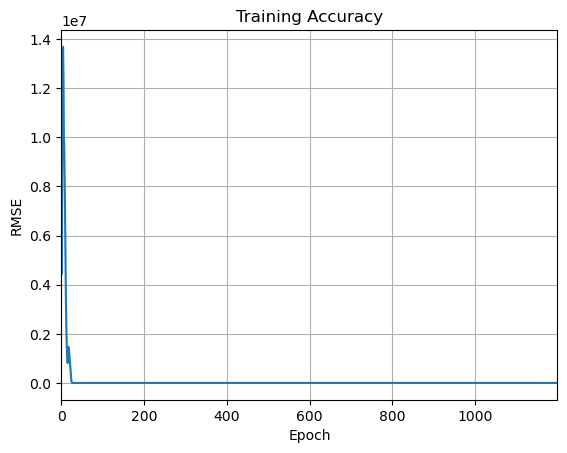

In [327]:

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
    #with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
       # print(i)
        model.train()
        #bar.set_description(f"Epoch {epoch}")
        #for start in bar:
        trainXT_seg = trainXT[i*batch_size:(i+1)*batch_size]
        trainyT_seg = trainyT[i*batch_size:(i+1)*batch_size]
        # Run the forward pass
        outputs = model(trainXT_seg)
        #loss = criterion(outputs, torch.max(trainyT_seg, 1)[1])
        loss = loss_fn(outputs, trainyT_seg)
        print(loss)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
        #bar.set_postfix(mse=float(loss))

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(testXT)
        mse = loss_fn(y_pred, testyT)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
     #loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        # Track the accuracy
        #total = trainyT_seg.size(0)
        #_, predicted = torch.max(outputs, 1)
        #_, actual = torch.max(trainyT_seg, 1)
       # correct = (predicted == actual).sum().item()
       # correct_sum = correct_sum + (correct/total)
       #acc_list.append(correct / total)
    #print("Epoch")
    #print(epoch)
    #print("accuracy")
    #print(correct_sum/int(np.floor(total_step/batch_size)))
    #acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))
# restore model and return best accuracy
model.load_state_dict(best_weights)
#plot the training accuracy
plt.title('Training Accuracy')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(history)
plt.show()

MSE: 15.29
RMSE: 3.91


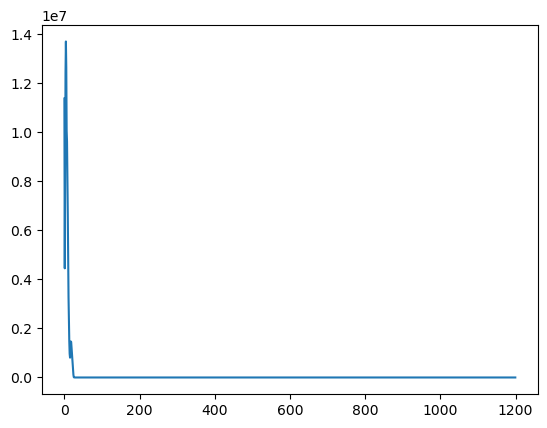

In [328]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()